## Previous code for data preprocessing

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Thu Jun 25 21:18:28 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P8    34W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Setting up the environment
! pip install numpy scipy matplotlib xarray pandas netcdf4 tqdm tensorflow scikit-learn seaborn

     |████████████████████████████████| 4.1MB 7.4MB/s 
     |████████████████████████████████| 327kB 41.2MB/s 


In [3]:
import s3fs
import seaborn as sns
import pandas as pd
import pyarrow
import re
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from os.path import join, exists
from matplotlib.colors import LogNorm
import tensorflow as tf
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from sklearn.model_selection import GroupKFold
from tensorflow.keras.optimizers import Adam
%matplotlib inline

seed = 8886
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
# Load functions. Copied from the instruction notebook.
# -----------------------------------------------
""" Data Processing """

def fetch_data(f):
    """ Load data directly from Amazon S3 storage """
    
    obj = fs.open(f)
    df = pd.read_parquet(obj)
    return df

# def prepare_data(data, input_columns, output_columns):
#     """ Splits data to input/output with corresponding lag """
    
#     data['id'] = data['id'].apply(lambda x: int(x[3:])) # change expnumber to int for sorting
#     data.index.name = 'indx'
#     data = data.sort_values(['id','indx'])
#     x_data = data[input_columns].iloc[:-1, :]
#     y_data = data[output_columns].iloc[1:, :]
    
#     return x_data, y_data

def prepare_data(data, input_columns, output_columns):
    """ Splits data to input/output with corresponding lag """
    data['id'] = data['id'].apply(lambda x: int(x[3:])) # change expnumber to int for sorting
    data.index.name = 'indx'
    data = data.sort_values(['id','indx'])
    # lag in/out by experiment
    mask = data['Time [s]'] != data['Time [s]'].max()
    x_data = data.loc[mask, input_columns]
    mask = data['Time [s]'] != data['Time [s]'].min()
    y_data = data.loc[mask, output_columns]
    return x_data, y_data

def get_starting_conds(data, input_vars, exp, starting_ts=0):
    """ Take data and expiriment number to gather initial starting condition for box emulator"""
    exp_data = data[data['id'] == exp]
    
    if exp_data.shape[0] == 0:
        raise ValueError('That expiriment number does not exist in this dataset.')
    
    ts_data = exp_data.iloc[starting_ts:starting_ts+1, :]

    return ts_data
# -----------------------------------------------
""" Evaluation """

def calc_pdf_hist(x, x_bins):
    return np.histogram(x, x_bins, density=True)[0]

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def hellinger(x, pdf_p, pdf_q):
    pdf_distances = (np.sqrt(pdf_p) - np.sqrt(pdf_q)) ** 2
    return np.trapz(pdf_distances, x) / 2

def hellinger_distance(y_true, y_pred, bins=50):
    bin_points = np.linspace(np.minimum(y_true.min(), y_pred.min()),
                       np.maximum(y_true.max(), y_pred.max()),
                       bins)
    bin_centers = 0.5 * (bin_points[:-1] + bin_points[1:])
    y_true_pdf = calc_pdf_hist(y_true, bin_points)
    y_pred_pdf = calc_pdf_hist(y_pred, bin_points)
    return hellinger(bin_centers, y_true_pdf, y_pred_pdf)

def r2_corr(y_true, y_pred):
    return np.corrcoef(y_true, y_pred)[0, 1] ** 2

def evaluate_mod(true_output, model_results):
    
    print('RMSE: Precursor: {:.5f}, Gas: {:.5f}, Aerosols: {:.5f}'.format(
        rmse(true_output.iloc[:,0], model_results.iloc[:,0]),
        rmse(true_output.iloc[:,1], model_results.iloc[:,1]),
        rmse(true_output.iloc[:,2], model_results.iloc[:,2])))
    print('R2: Precursor: {:.5f}, Gas: {:.5f}, Aerosols: {:.5f}'.format(
        r2_corr(true_output.iloc[:,0], model_results.iloc[:,0]),
        r2_corr(true_output.iloc[:,1], model_results.iloc[:,1]),
        r2_corr(true_output.iloc[:,2], model_results.iloc[:,2])))
    print('Hellenger Distance: Precursor: {:.5f}, Gas: {:.5f}, Aerosols: {:.5f}'.format(
        hellinger_distance(true_output.iloc[:,0], model_results.iloc[:,0]),
        hellinger_distance(true_output.iloc[:,1], model_results.iloc[:,1]),
        hellinger_distance(true_output.iloc[:,2], model_results.iloc[:,2])))
    
    return
# -----------------------------------------------
""" Models """
def dense_neural_net(num_layers=2, num_neurons=100, activation="relu", learning_rate=0.001,
                     num_input_columns=9, num_output_columns=3):
    """ Build and return dense neural network with specified hyperparameters"""
    
    input_layer = Input(num_input_columns)
    n_net = input_layer
    for l in range(num_layers):
        n_net= Dense(num_neurons, activation=activation)(n_net)
    out = Dense(num_output_columns)(n_net)
    mod = Model(input_layer, out)
    mod.compile(Adam(learning_rate=learning_rate), "mse")
    
    return mod

def box_emulator(neural_network, starting_conds, input_scaler, output_scaler, num_timesteps=1439):
    """ Forward box emulator
    Args:
        neural_netwrok: NN model object that predits output at t+1
        starting_conds: Initial input conditions used for first prediction
        input_scaler: Input scaler object
        onput_scaler: Onput scaler object
        num_timesteps: how many timesteps forward to run emulator
    Returns:
        results: Pandas DataFrame of box emulator output
    """
    mod = neural_network
    scaled_input = input_scaler.transform(starting_conds.iloc[:,1:-1])
    static_input = scaled_input[:,-6:]

    for i in range(num_timesteps):

        if i == 0:

            pred = mod.predict(scaled_input)
            new_input = np.concatenate([pred,static_input], axis=1)
            pred_array = pred

        else:

            pred = mod.predict(new_input)
            new_input = np.concatenate([pred,static_input], axis=1)
            pred_array = np.concatenate([pred_array, pred], axis=0)
            
    results = pd.DataFrame(output_scaler.inverse_transform(pred_array))
    results['id'] = starting_conds.iloc[0,-1]
    results.columns = starting_conds.columns[[1,2,3,-1]]
    return results

# def run_emulator_ensemble(input_data, mod, num_expiriments, input_vars, input_scaler, 
#                           output_scaler, run_length=1439):
#     """ Run an ensemble of emulators on n amount of random expiriments
#     Args:
#         input_data: unscaled dataframe collection of expiriment data
#         mod: NN model object that predits output at t+1
#         num_expiriments: How many expiriments to run
#         input_vars: Input variables for model
#         output_vars: Output variables for model
#         run_length: number of timesteps to run each emulator forward
#     Returns:
#         pred_df: Aggregated Pandas DataFrame of predictions for each expiriment
#         true_df: Corresponding Dataframe with raw expiriment data
#     """
    output_cols = input_data.columns[[1,2,3, -1]]
    exps = sorted(random.sample(list(input_data['id'].unique()), num_expiriments))
    pred_df  = pd.DataFrame(columns = output_cols)
    true_df = input_data.loc[input_data['id'].isin(exps)][output_cols].reset_index(drop=True)
    true_df =  true_df.groupby('id').apply(lambda x: x.iloc[1:,:]).reset_index(drop=True)  
    
    for i in range(num_expiriments):
        
        init_conds = get_starting_conds(input_data, input_vars, exps[i])
        preds = box_emulator(mod, init_conds, input_scaler, output_scaler, run_length)
        preds['id'] = exps[i]
        preds.columns = pred_df.columns
        pred_df = pred_df.append(preds, ignore_index=True)

    return pred_df, true_df

def run_emulator_ensemble(input_data, output_data, mod, num_expiriments, input_vars, input_scaler, 
                          output_scaler, run_length=1439):
    """ Run an ensemble of emulators on n amount of random expiriments
    Args:
        input_data: unscaled dataframe collection of expiriment data
        mod: NN model object that predits output at t+1
        num_expiriments: How many expiriments to run
        input_vars: Input variables for model
        output_vars: Output variables for model
        run_length: number of timesteps to run each emulator forward
    Returns:
        pred_df: Aggregated Pandas DataFrame of predictions for each expiriment
        true_df: Corresponding Dataframe with raw expiriment data
    """
    output_cols = input_data.columns[[1,2,3, -1]]
    exps = sorted(random.sample(list(input_data['id'].unique()), num_expiriments))
    pred_df  = pd.DataFrame(columns = output_cols)
    true_df = output_data.loc[output_data['id'].isin(exps)].iloc[:,1:-1].reset_index(drop=True)
     
    for i in range(num_expiriments):
        init_conds = get_starting_conds(input_data, input_vars, exps[i])
        preds = box_emulator(mod, init_conds, input_scaler, output_scaler, run_length)
        preds['id'] = exps[i]
        preds.columns = pred_df.columns
        pred_df = pred_df.append(preds, ignore_index=True)
    return pred_df, true_df

Load the data

In [5]:
# load data
fs = s3fs.S3FileSystem(anon=True)
gecko_files = fs.ls("ncar-aiml-data-commons/gecko/")[1:]
test, train, val = map(fetch_data, gecko_files)

In [6]:
train.head()

,Time [s],Precursor [ug/m3],Gas [ug/m3],Aerosol [ug_m3],temperature (K),solar zenith angle (degree),pre-existing aerosols (ug/m3),o3 (ppb),nox (ppb),oh (10^6 molec/cm3),id
0,1.000000,0.069675,0.000000,0.000000,264.135037,78.052738,0.022782,38.768707,0.206029,7.360145,Exp1666
1,301.207794,0.067673,0.002783,0.000001,264.135037,78.052738,0.022782,38.768707,0.206029,7.360145,Exp1666
2,601.415588,0.065728,0.005749,0.000004,264.135037,78.052738,0.022782,38.768707,0.206029,7.360145,Exp1666
3,901.623352,0.063838,0.008627,0.000008,264.135037,78.052738,0.022782,38.768707,0.206029,7.360145,Exp1666
4,1201.831177,0.062003,0.011420,0.000013,264.135037,78.052738,0.022782,38.768707,0.206029,7.360145,Exp1666


In [7]:
# get some summary statistics of the training data
train.groupby('id').mean().describe()

,Time [s],Precursor [ug/m3],Gas [ug/m3],Aerosol [ug_m3],temperature (K),solar zenith angle (degree),pre-existing aerosols (ug/m3),o3 (ppb),nox (ppb),oh (10^6 molec/cm3)
count,1.400000e+03,1400.000000,1400.000000,1400.000000,1400.000000,1400.000000,1400.000000,1400.000000,1400.000000,1400.000000
mean,2.160005e+05,0.003125,0.027601,0.032703,277.413314,44.923263,11.388653,75.422052,2.124920,5.493831
std,2.329138e-10,0.002215,0.013710,0.020581,21.712817,26.064725,21.082846,43.495636,2.468413,2.582480
min,2.160005e+05,0.001244,0.004393,0.001704,240.024774,0.018612,0.010031,1.017131,0.100186,1.011878
25%,2.160005e+05,0.001598,0.016943,0.015331,258.824046,22.235231,0.099235,36.417272,0.314910,3.231017
50%,2.160005e+05,0.002253,0.024975,0.028837,277.096217,44.858750,1.085966,76.044879,1.004467,5.479992
75%,2.160005e+05,0.003803,0.035183,0.048352,296.098148,68.039551,10.946353,112.534705,3.059370,7.758317
max,2.160005e+05,0.012054,0.079415,0.086156,314.980647,89.966654,99.280288,149.927193,9.980638,9.999925


In [8]:
# Data Preperation
'''
Copied from the instruction notebook

Here we prepare the data for machine learning by taking the respective variables 
from each column, offsetting the output data by 1 timestep (this is done inside 
the `prepare_data()` function, and scale. Make sure to not re-fit the scaler on 
the validation/test data and only `transform()` it. 
'''

input_vars, output_vars = train.columns, train.columns[[0,1,2,3,-1]]
train_in, train_out = prepare_data(train, input_vars, output_vars)
val_in, val_out = prepare_data(val, input_vars, output_vars)

Data scaling

In [9]:
# Min max scaling
input_scaler = MinMaxScaler()
output_scaler = MinMaxScaler()

scaled_train_in = input_scaler.fit_transform(train_in.iloc[:,1:-1])
scaled_train_out = output_scaler.fit_transform(train_out.iloc[:,1:-1])
scaled_val_in = input_scaler.transform(val_in.iloc[:,1:-1])
scaled_val_out = output_scaler.transform(val_out.iloc[:,1:-1])

In [10]:
scaled_train_in.shape, scaled_train_out.shape, scaled_val_in.shape, scaled_val_out.shape

((2014600, 9), (2014600, 3), (287800, 9), (287800, 3))

In [11]:
# Standardizing
input_std_scaler = StandardScaler()
output_std_scaler = StandardScaler()

scaled_std_train_in = input_std_scaler.fit_transform(train_in.iloc[:,1:-1])
scaled_std_train_out = output_std_scaler.fit_transform(train_out.iloc[:,1:-1])
scaled_std_val_in = input_std_scaler.transform(val_in.iloc[:,1:-1])
scaled_std_val_out = output_std_scaler.transform(val_out.iloc[:,1:-1])

In [12]:
scaled_std_train_in.shape, scaled_std_train_out.shape, scaled_std_val_in.shape, scaled_std_val_out.shape

((2014600, 9), (2014600, 3), (287800, 9), (287800, 3))

## Baseline model and previous ML model

In [88]:
%%time
tf.random.set_seed(seed)
mod = dense_neural_net()
history = mod.fit(scaled_train_in, scaled_train_out, validation_data=(scaled_val_in, scaled_val_out), 
                  batch_size=256, epochs=5, verbose=1)
mod.summary()

Epoch 1/5
7870/7870 [==============================] - 22s 3ms/step - loss: 2.7214e-04 - val_loss: 4.8278e-06
Epoch 2/5
7870/7870 [==============================] - 22s 3ms/step - loss: 3.1891e-06 - val_loss: 2.6881e-06
Epoch 3/5
7870/7870 [==============================] - 22s 3ms/step - loss: 2.2360e-06 - val_loss: 9.9619e-07
Epoch 4/5
7870/7870 [==============================] - 22s 3ms/step - loss: 1.7544e-06 - val_loss: 2.2398e-06
Epoch 5/5
7870/7870 [==============================] - 22s 3ms/step - loss: 1.4408e-06 - val_loss: 1.2054e-06
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 9)]               0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               1000      
_________________________________________________________________
dense_4 (Dense)              (None, 100

In [89]:
# get predictions and truth

# pred_nn = pd.DataFrame(output_scaler.inverse_transform(mod.predict(scaled_val_in))).iloc[1:,:]
# true_val = val_out.iloc[:-1,1:4]

pred_nn = pd.DataFrame(output_scaler.inverse_transform(mod.predict(scaled_val_in)))
true_val = val_out.iloc[:,1:-1]

print('Metrics for base model:')
evaluate_mod(true_val, pred_nn)

Metrics for base model:
RMSE: Precursor: 0.00003, Gas: 0.00018, Aerosols: 0.00009
R2: Precursor: 1.00000, Gas: 0.99999, Aerosols: 0.99999
Hellenger Distance: Precursor: 0.00000, Gas: 0.00009, Aerosols: 0.00005


In [100]:
output_columns = ['Precursor [ug/m3]', 'Gas [ug/m3]', 'Aerosol [ug_m3]']
pred_nn.columns = output_columns

pred_train_nn = pd.DataFrame(output_scaler.inverse_transform(mod.predict(scaled_train_in)))
pred_train_nn.columns = output_columns

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """


Baseline model with standardized input.

In [ ]:
%%time
tf.random.set_seed(seed)
mod_std = dense_neural_net()
history = mod_std.fit(scaled_train_in, scaled_train_out, validation_data=(scaled_std_val_in, scaled_std_val_out), 
                  batch_size=256, epochs=5, verbose=1)
mod_std.summary()

Epoch 1/5
7870/7870 [==============================] - 27s 3ms/step - loss: 2.7206e-04 - val_loss: 0.1394
Epoch 2/5
7870/7870 [==============================] - 26s 3ms/step - loss: 3.2016e-06 - val_loss: 0.1326
Epoch 3/5
7870/7870 [==============================] - 26s 3ms/step - loss: 2.2764e-06 - val_loss: 0.1289
Epoch 4/5
7870/7870 [==============================] - 26s 3ms/step - loss: 1.7520e-06 - val_loss: 0.1266
Epoch 5/5
7870/7870 [==============================] - 27s 3ms/step - loss: 1.4404e-06 - val_loss: 0.1260
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 9)]               0         
_________________________________________________________________
dense_43 (Dense)             (None, 100)               1000      
_________________________________________________________________
dense_44 (Dense)             (None, 100)               10

In [ ]:
# get predictions and truth

# pred_nn = pd.DataFrame(output_std_scaler.inverse_transform(mod.predict(scaled_std_val_in))).iloc[1:,:]
# true_val = val_out.iloc[:-1,1:4]

pred_nn_std = pd.DataFrame(output_std_scaler.inverse_transform(mod_std.predict(scaled_std_val_in)))
true_val = val_out.iloc[:,1:-1]

print('Metrics for base model:')
evaluate_mod(true_val, pred_nn_std)

Metrics for base model:
RMSE: Precursor: 0.00246, Gas: 0.00952, Aerosols: 0.00884
R2: Precursor: 0.98158, Gas: 0.95517, Aerosols: 0.95286
Hellenger Distance: Precursor: 0.26690, Gas: 0.18135, Aerosols: 0.09445


## Evaluate two interpretation methods for your machine learning solution

### Models to evaluate

The RNN Model to evaluate:

In [ ]:
from tensorflow.keras.layers import LSTM, SimpleRNN
from tensorflow.keras.models import Sequential

tf.random.set_seed(seed)

# Transform the model for use in RNN
# previously applied transformer: output_std_scaler
rnn_std_train_in = scaled_std_train_in.reshape(-1,1,9)
rnn_std_train_out = scaled_std_train_out.reshape(-1,1,3)
rnn_std_val_in = scaled_std_val_in.reshape(-1,1,9)
rnn_std_val_out = scaled_std_val_out.reshape(-1,1,3)

# Set up the model
mod_rnn_std_2 = Sequential()
mod_rnn_std_2.add(SimpleRNN(128, input_shape=(1, 9), return_sequences=True))
mod_rnn_std_2.add(LSTM(256, return_sequences=True))
mod_rnn_std_2.add(Dense(3))
mod_rnn_std_2.compile(Adam(learning_rate=0.001), "mse")

# fit the model
history = mod_rnn_std_2.fit(rnn_std_train_in, rnn_std_train_out, 
                      validation_data=(rnn_std_val_in, rnn_std_val_out), 
                      batch_size=256, epochs=5, verbose=1, workers=-1)
mod_rnn_std_2.summary()

# get predictions and truth
pred_rnn_std_reshape_2 = mod_rnn_std_2.predict(rnn_std_val_in).reshape(scaled_std_val_out.shape)
pred_rnn_std_2 = pd.DataFrame(output_std_scaler.inverse_transform(pred_rnn_std_reshape_2))
true_val = val_out.iloc[:,1:-1]

print('Metrics for LSTM model:')
evaluate_mod(true_val, pred_rnn_std_2)

Epoch 1/5
7870/7870 [==============================] - 55s 7ms/step - loss: 0.0013 - val_loss: 1.1885e-04
Epoch 2/5
7870/7870 [==============================] - 55s 7ms/step - loss: 2.4182e-05 - val_loss: 1.6885e-05
Epoch 3/5
7870/7870 [==============================] - 54s 7ms/step - loss: 1.9606e-05 - val_loss: 1.0075e-05
Epoch 4/5
7870/7870 [==============================] - 55s 7ms/step - loss: 1.4716e-05 - val_loss: 1.0276e-05
Epoch 5/5
7870/7870 [==============================] - 54s 7ms/step - loss: 1.3341e-05 - val_loss: 1.0726e-05
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_2 (SimpleRNN)     (None, 1, 128)            17664     
_________________________________________________________________
lstm (LSTM)                  (None, 1, 256)            394240    
_________________________________________________________________
dense_2 (Dense)              (None, 

In [83]:
output_columns = ['Precursor [ug/m3]', 'Gas [ug/m3]', 'Aerosol [ug_m3]']
pred_rnn_std_2.columns = output_columns

pred_train_rnn_std_reshape_2 = mod_rnn_std_2.predict(rnn_std_train_in).reshape(scaled_std_train_out.shape)
pred_train_rnn_std_2 = pd.DataFrame(output_std_scaler.inverse_transform(pred_train_rnn_std_reshape_2))

pred_train_rnn_std_2.columns = output_columns

Linear model to evaluate

In [ ]:
# from sklearn import linear_model
# lmod = linear_model.LinearRegression().fit(scaled_std_train_in, scaled_std_train_out)

# # get predictions and truth
# pred_lmod_raw = lmod.predict(scaled_std_val_in)
# pred_lmod = pd.DataFrame(output_std_scaler.inverse_transform(pred_rnn_std_reshape_8))
# true_val = val_out.iloc[:,1:-1]

# print('Metrics for Linear model:')
# evaluate_mod(true_val, pred_lmod)

Metrics for Linear model:
RMSE: Precursor: 0.00084, Gas: 0.00069, Aerosols: 0.00092
R2: Precursor: 0.99244, Gas: 0.99922, Aerosols: 0.99827
Hellenger Distance: Precursor: 0.00097, Gas: 0.00068, Aerosols: 0.00232


In [ ]:
index_columns = ['Time [s]', 'id']
output_columns = ['Precursor [ug/m3]', 'Gas [ug/m3]', 'Aerosol [ug_m3]']
input_columns = list(set(train.columns) - set(index_columns))

def train_model():
    est= {}
    msqe = {}
    for j, col in enumerate(['Precursor [ug/m3]', 'Gas [ug/m3]', 'Aerosol [ug_m3]']):
        e = linear_model.LinearRegression().fit(scaled_std_train_in, scaled_std_train_out[:,j])
#         e = svm.LinearSVR(tol=0.9).fit(train_in_scaled, train_out_scaled[:,j])
        msqe[col] = mean_squared_error(scaled_std_val_out[:,j], e.predict(scaled_std_val_in))
        est[col] = e
    return msqe, est

In [ ]:
msqe, est = train_model()

fit_train = {col: est[col].predict(scaled_std_train_in) for col in output_columns}
fit_val = {col: est[col].predict(scaled_std_val_in) for col in output_columns}
train_out_arr = np.concatenate([fit_train[col][:,np.newaxis] for col in output_columns], axis=-1)
val_out_arr = np.concatenate([fit_val[col][:,np.newaxis] for col in output_columns], axis=-1)
linear_mod_train = pd.DataFrame(output_std_scaler.inverse_transform(train_out_arr), columns=output_columns)
linear_mod_val = pd.DataFrame(output_std_scaler.inverse_transform(val_out_arr), columns=output_columns)

Random Forest Model to evaluate

In [134]:
from sklearn.ensemble import RandomForestRegressor
# Instantiate model 
model_rf = RandomForestRegressor(n_estimators=20, max_depth=5)
# Train the model with training set
model_rf.fit(scaled_std_train_in, scaled_std_train_out)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=5, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=20, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [135]:
# Score
print('Training data score: ' + str(model_rf.score(scaled_std_train_in, scaled_std_train_out)))
print('Testing data score: ' + str(model_rf.score(scaled_std_val_in, scaled_std_val_out)))

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


Training data score: 0.9558880993196023
Testing data score: 0.9568028519353541


/usr/local/lib/python3.6/dist-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


In [136]:
# get predictions and truth
pred_rf = pd.DataFrame(output_std_scaler.inverse_transform(model_rf.predict(scaled_std_val_in)))
true_val = val_out.iloc[:,1:4]

print('Metrics for random forest model:')
evaluate_mod(true_val, pred_rf)

Metrics for random forest model:
RMSE: Precursor: 0.00135, Gas: 0.00564, Aerosols: 0.00518
R2: Precursor: 0.98030, Gas: 0.94650, Aerosols: 0.94536
Hellenger Distance: Precursor: 0.04319, Gas: 0.31254, Aerosols: 0.33035


In [137]:
output_columns = ['Precursor [ug/m3]', 'Gas [ug/m3]', 'Aerosol [ug_m3]']
pred_rf.columns = output_columns

pred_train_rf = pd.DataFrame(output_std_scaler.inverse_transform(model_rf.predict(scaled_std_train_in)))
pred_train_rf.columns = output_columns


Simple RNN

In [138]:
from tensorflow.keras.layers import LSTM, SimpleRNN
from tensorflow.keras.models import Sequential

tf.random.set_seed(seed)

# Transform the model for use in RNN
# previously applied transformer: output_std_scaler
rnn_std_train_in = scaled_std_train_in.reshape(-1,1,9)
rnn_std_train_out = scaled_std_train_out.reshape(-1,1,3)
rnn_std_val_in = scaled_std_val_in.reshape(-1,1,9)
rnn_std_val_out = scaled_std_val_out.reshape(-1,1,3)

# Set up the model
mod_rnn_std_simple = Sequential()
mod_rnn_std_simple.add(SimpleRNN(256, input_shape=(1, 9), return_sequences=True))
mod_rnn_std_simple.add(Dense(3))
mod_rnn_std_simple.compile(Adam(learning_rate=0.001), "mse")

# fit the model
history = mod_rnn_std_simple.fit(rnn_std_train_in, rnn_std_train_out, 
                      validation_data=(rnn_std_val_in, rnn_std_val_out), 
                      batch_size=256, epochs=5, verbose=1, workers=-1)
mod_rnn_std_simple.summary()

# get predictions and truth
pred_rnn_std_reshape_simple = mod_rnn_std_simple.predict(rnn_std_val_in).reshape(scaled_std_val_out.shape)
pred_rnn_std_simple = pd.DataFrame(output_std_scaler.inverse_transform(pred_rnn_std_reshape_simple))
true_val = val_out.iloc[:,1:-1]

print('Metrics for LSTM model:')
evaluate_mod(true_val, pred_rnn_std_simple)

Epoch 1/5
7870/7870 [==============================] - 40s 5ms/step - loss: 0.0013 - val_loss: 2.6488e-05
Epoch 2/5
7870/7870 [==============================] - 38s 5ms/step - loss: 2.1144e-05 - val_loss: 9.6862e-06
Epoch 3/5
7870/7870 [==============================] - 39s 5ms/step - loss: 1.5822e-05 - val_loss: 1.4888e-05
Epoch 4/5
7870/7870 [==============================] - 38s 5ms/step - loss: 1.4162e-05 - val_loss: 1.2673e-05
Epoch 5/5
7870/7870 [==============================] - 39s 5ms/step - loss: 1.3159e-05 - val_loss: 1.3192e-05
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_3 (SimpleRNN)     (None, 1, 256)            68096     
_________________________________________________________________
dense_6 (Dense)              (None, 1, 3)              771       
Total params: 68,867
Trainable params: 68,867
Non-trainable params: 0
________________________________

In [139]:
output_columns = ['Precursor [ug/m3]', 'Gas [ug/m3]', 'Aerosol [ug_m3]']
pred_rnn_std_simple.columns = output_columns

pred_train_rnn_std_reshape_simple = mod_rnn_std_simple.predict(rnn_std_train_in).reshape(scaled_std_train_out.shape)
pred_train_rnn_std_simple = pd.DataFrame(output_std_scaler.inverse_transform(pred_train_rnn_std_reshape_simple))

pred_train_rnn_std_simple.columns = output_columns

LSTM

In [140]:
from tensorflow.keras.layers import LSTM, SimpleRNN
from tensorflow.keras.models import Sequential

tf.random.set_seed(seed)

# Transform the model for use in RNN
# previously applied transformer: output_std_scaler
rnn_std_train_in = scaled_std_train_in.reshape(-1,1,9)
rnn_std_train_out = scaled_std_train_out.reshape(-1,1,3)
rnn_std_val_in = scaled_std_val_in.reshape(-1,1,9)
rnn_std_val_out = scaled_std_val_out.reshape(-1,1,3)

# Set up the model
mod_rnn_std_lstm = Sequential()
mod_rnn_std_lstm.add(SimpleRNN(256, input_shape=(1, 9), return_sequences=True))
mod_rnn_std_lstm.add(Dense(3))
mod_rnn_std_lstm.compile(Adam(learning_rate=0.001), "mse")

# fit the model
history = mod_rnn_std_lstm.fit(rnn_std_train_in, rnn_std_train_out, 
                      validation_data=(rnn_std_val_in, rnn_std_val_out), 
                      batch_size=256, epochs=5, verbose=1, workers=-1)
mod_rnn_std_lstm.summary()

# get predictions and truth
pred_rnn_std_reshape_lstm = mod_rnn_std_lstm.predict(rnn_std_val_in).reshape(scaled_std_val_out.shape)
pred_rnn_std_lstm = pd.DataFrame(output_std_scaler.inverse_transform(pred_rnn_std_reshape_lstm))
true_val = val_out.iloc[:,1:-1]

print('Metrics for LSTM model:')
evaluate_mod(true_val, pred_rnn_std_lstm)

Epoch 1/5
7870/7870 [==============================] - 38s 5ms/step - loss: 0.0013 - val_loss: 2.6489e-05
Epoch 2/5
7870/7870 [==============================] - 39s 5ms/step - loss: 2.1144e-05 - val_loss: 9.6868e-06
Epoch 3/5
7870/7870 [==============================] - 38s 5ms/step - loss: 1.5821e-05 - val_loss: 1.4885e-05
Epoch 4/5
7870/7870 [==============================] - 38s 5ms/step - loss: 1.4162e-05 - val_loss: 1.2684e-05
Epoch 5/5
7870/7870 [==============================] - 37s 5ms/step - loss: 1.3170e-05 - val_loss: 1.2955e-05
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_4 (SimpleRNN)     (None, 1, 256)            68096     
_________________________________________________________________
dense_7 (Dense)              (None, 1, 3)              771       
Total params: 68,867
Trainable params: 68,867
Non-trainable params: 0
________________________________

In [141]:
output_columns = ['Precursor [ug/m3]', 'Gas [ug/m3]', 'Aerosol [ug_m3]']
pred_rnn_std_lstm.columns = output_columns

pred_train_rnn_std_reshape_lstm = mod_rnn_std_lstm.predict(rnn_std_train_in).reshape(scaled_std_train_out.shape)
pred_train_rnn_std_lstm = pd.DataFrame(output_std_scaler.inverse_transform(pred_train_rnn_std_reshape_lstm))

pred_train_rnn_std_lstm.columns = output_columns

### Taylor Diagram

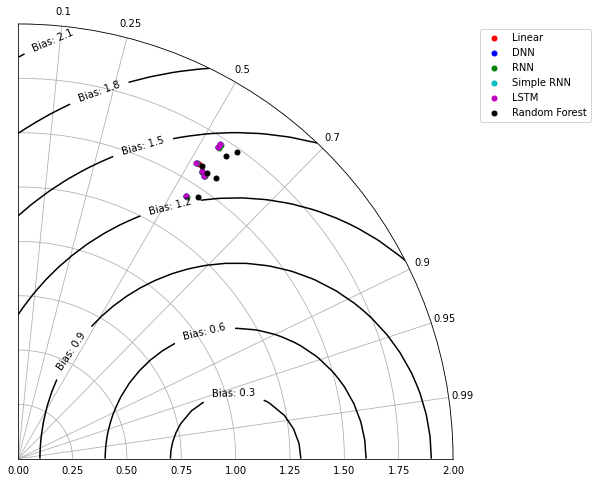

In [149]:
train_model_outputs = {
    'Linear Train': linear_mod_train,
    'DNN Train': pred_train_nn,
    'RNN Train': pred_train_rnn_std_2,
    'Simple RNN Train': pred_train_rnn_std_simple,
    'LSTM Train': pred_train_rnn_std_lstm,
    'Random Forest Train': pred_train_rf,
    'Linear Val':linear_mod_val,
    'DNN Val': pred_nn,
    'RNN Val': pred_rnn_std_2, 
    'Simple RNN Val': pred_rnn_std_simple,
    'LSTM Val': pred_rnn_std_lstm,
    'Random Forest Val': pred_rf
}
truth = {
    'Train': true_val,
    'Val': true_val
}

def get_stats(truth, models):
    stats = pd.DataFrame(index=['MAE', 'RMSE', 'R', 'Hellinger Distance', 'STDVAR', 'Truth STDVAR', 'Col', 'Model Type'])
    for col in truth.columns.values:
        for model_name, model in models.items():
            mae = (truth[col] - model[col]).abs().mean()
            rmse = np.sqrt(((truth[col] - model[col])**2).mean())
            pearson_corr = ((truth[col]*model[col]).mean() - truth[col].mean()*model[col].mean())/(truth[col].std()*model[col].std())
            hd = hellinger_distance(truth[col].values, model[col].values)
            model_std = model[col].std()
            truth_std = truth[col].std()
            stats[f'{model_name} {col}'] = np.array([mae, rmse, pearson_corr, hd, model_std, truth_std, col, model_name])
    return stats.transpose().reset_index().drop(columns='index') #.reset_index().set_index(['Col', 'Model Type'])

df_all_val = get_stats(truth['Val'], {f'{t} Val': train_model_outputs[f'{t} Val'] for t in ['Linear', 'DNN', 'RNN', 'Simple RNN', 'LSTM', 'Random Forest']})
scores_val = {outname: df_out.set_index('Model Type').drop(columns='Col') for outname, df_out in df_all_val.groupby('Col')}
df_all_train = get_stats(truth['Val'], {f'{t} Train': train_model_outputs[f'{t} Train'] for t in ['Linear', 'DNN', 'RNN', 'Simple RNN', 'LSTM', 'Random Forest']})
scores_train = {outname: df_out.set_index('Model Type').drop(columns='Col') for outname, df_out in df_all_train.groupby('Col')}

import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots(figsize=(8,8), subplot_kw=dict(projection='polar'))
corrs = [0.1, 0.25, 0.5, 0.7, 0.9,0.95, 0.99]
theta_corrs = np.arccos(corrs)*180./np.pi
ax.set_thetamax(90)
ax.set_thetagrids(theta_corrs, corrs)
var_space, theta_space = np.meshgrid(np.linspace(0,2,30), np.linspace(0,np.pi/2, 30))
bias_contours = np.sqrt(var_space**2+1-2*var_space*np.cos(theta_space))
contours = ax.contour(theta_space, var_space, bias_contours, colors='k')
ax.clabel(contours, contours.levels, inline=True, fmt='Bias: %2.1f', fontsize=10)
colors = ['r', 'b', 'g', 'c', 'm', 'k']
for modeltype, color in zip(['Linear', 'DNN', 'RNN', 'Simple RNN', 'LSTM', 'Random Forest'], colors):
    r = []
    stdvar_norms = []
    labels = []
    for datatype, dataset in zip(['Train', 'Val'], [scores_train, scores_val]):
        for component in output_columns:
            element_r = float(dataset[component].loc[f'{modeltype} {datatype}', 'R'])
            r.append(element_r)
            std = float(dataset[component].loc[f'{modeltype} {datatype}', 'STDVAR'])
            truth_std = float(dataset[component].loc[f'{modeltype} {datatype}', 'Truth STDVAR'])
            stdvar_norms.append(std/truth_std)
#             ax.text(std/truth_std, np.arccos(element_r),f'{datatype}')
    ax.scatter( stdvar_norms,np.arccos(r), color=color, label=modeltype, s = 25)
ax.legend(loc=2, bbox_to_anchor=(1.05,1))

### Validation Curves

Validation curve here was plotted with a different model: this RNN model has its input formatted as 3-d array to show time series.

In [ ]:
# Data reprocessing
def time_series(df, colnum):
    '''
    turn dataframe into multi-index dataframe, then to xarray dataset,
    then to xarray dataarray. After that, transpose to the required 
    input shape ([batch, timesteps, feature]).

    returns the 3-d np array above in 2-d (-1,colnum) format so it can be
    standardized or scaled.
    '''
    data_array = df.set_index(['id','Time [s]']).to_xarray().to_array()
    array = data_array.transpose('id','Time [s]', 'variable').values

    return array.reshape(-1, colnum) # reshaped to scaled with xx_std_scaler

# np.shape(time_series(train_in, 9))
# # (2014600, 9)

# actual shape is (1400, 1439, 9)

In [ ]:
# Data preprocessing
# Standardizing
input_std_scaler = StandardScaler()
output_std_scaler = StandardScaler()

scaled_std_train_in_ts = input_std_scaler.fit_transform(time_series(train_in, 9))
scaled_std_train_out_ts = output_std_scaler.fit_transform(time_series(train_out, 3))
scaled_std_val_in_ts = input_std_scaler.transform(time_series(val_in, 9))
scaled_std_val_out_ts = output_std_scaler.transform(time_series(val_out, 3))

# reshape. note this time data is in [batch, timesteps, feature] size.
rnn_std_train_in_ts = scaled_std_train_in_ts.reshape(-1,1439,9)
rnn_std_train_out_ts = scaled_std_train_out_ts.reshape(-1,1439,3)
rnn_std_val_in_ts = scaled_std_val_in_ts.reshape(-1,1439,9)
rnn_std_val_out_ts = scaled_std_val_out_ts.reshape(-1,1439,3)

In [ ]:
from tensorflow.keras.layers import LSTM, SimpleRNN
from tensorflow.keras.models import Sequential

tf.random.set_seed(seed)

# Set up the model
mod_rnn_std_8 = Sequential()
mod_rnn_std_8.add(SimpleRNN(256, input_shape=(1439, 9), return_sequences=True))
# mod_rnn_std_8.add(LSTM(256, return_sequences=True))
mod_rnn_std_8.add(Dense(3))
mod_rnn_std_8.compile(Adam(learning_rate=0.001), "mse")

# fit the model
# history = mod_rnn_std_8.fit(rnn_std_train_in_ts, rnn_std_train_out_ts, 
#                       validation_data=(rnn_std_val_in_ts, rnn_std_val_out_ts), 
#                       batch_size=10, epochs=5, verbose=1, workers=-1)

history = mod_rnn_std_8.fit(rnn_std_train_in_ts, rnn_std_train_out_ts, 
                      validation_data=(rnn_std_val_in_ts, rnn_std_val_out_ts), 
                      batch_size=256, epochs=1000, verbose=1, workers=-1)

mod_rnn_std_8.summary()

# get predictions and truth
pred_rnn_std_8 = mod_rnn_std_8.predict(rnn_std_val_in_ts).reshape(-1,3)
pred_rnn_std_reshape_8 = mod_rnn_std_8.predict(rnn_std_val_in_ts).reshape(scaled_std_val_out.shape)
pred_rnn_std_reverse_8 = pd.DataFrame(output_std_scaler.inverse_transform(pred_rnn_std_reshape_8)).iloc[1:,:]
true_val = val_out.iloc[:-1,1:4]

print('Metrics for LSTM model:')
evaluate_mod(true_val, pred_rnn_std_reverse_8)

Epoch 1/1000
6/6 [==============================] - 8s 1s/step - loss: 0.4068 - val_loss: 0.0827
Epoch 2/1000
6/6 [==============================] - 7s 1s/step - loss: 0.0606 - val_loss: 0.0394
Epoch 3/1000
6/6 [==============================] - 7s 1s/step - loss: 0.0305 - val_loss: 0.0201
Epoch 4/1000
6/6 [==============================] - 7s 1s/step - loss: 0.0194 - val_loss: 0.0149
Epoch 5/1000
6/6 [==============================] - 8s 1s/step - loss: 0.0134 - val_loss: 0.0119
Epoch 6/1000
6/6 [==============================] - 8s 1s/step - loss: 0.0110 - val_loss: 0.0095
Epoch 7/1000
6/6 [==============================] - 8s 1s/step - loss: 0.0089 - val_loss: 0.0082
Epoch 8/1000
6/6 [==============================] - 7s 1s/step - loss: 0.0077 - val_loss: 0.0073
Epoch 9/1000
6/6 [==============================] - 7s 1s/step - loss: 0.0069 - val_loss: 0.0064
Epoch 10/1000
6/6 [==============================] - 8s 1s/step - loss: 0.0062 - val_loss: 0.0059
Epoch 11/1000
6/6 [==========

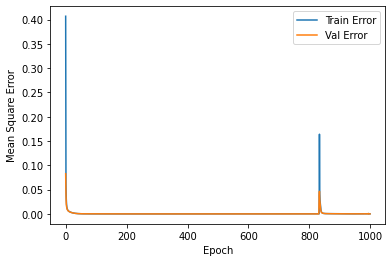

In [ ]:
def plot_history():
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error')
    plt.plot(hist['epoch'], hist['loss'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_loss'], label = 'Val Error')
    plt.legend()

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

plot_history()

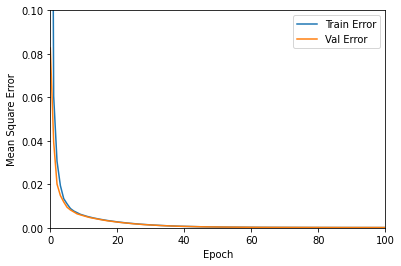

In [ ]:
def plot_history_short():
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error')
    plt.plot(hist['epoch'], hist['loss'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_loss'], label = 'Val Error')
    plt.legend()
    plt.xlim([0,100])
    plt.ylim([0,0.10])

plot_history_short()


## Compare interpretation of baseline with your approach

In [145]:
j=0
print('====================================')
print(output_columns[j])
print('====================================')
foo = scores_val[output_columns[j]]
for col in foo.columns:
    foo[col] = pd.to_numeric(foo[col])
foo.style.background_gradient(cmap='Reds', subset=['MAE', 'RMSE', 'Hellinger Distance']).background_gradient(cmap='Greens', subset=['R'])

Precursor [ug/m3]


,MAE,RMSE,R,Hellinger Distance,STDVAR,Truth STDVAR
Model Type,,,,,,
Linear Val,0.005001,0.013297,0.001411,0.000012,0.009640,0.009633
DNN Val,0.004986,0.013287,0.001939,0.000001,0.009637,0.009633
RNN Val,0.004987,0.013288,0.001937,0.000002,0.009643,0.009633
Simple RNN Val,0.004999,0.013295,0.002481,0.000002,0.009655,0.009633
LSTM Val,0.004999,0.013295,0.002426,0.000001,0.009654,0.009633
Random Forest Val,0.004940,0.013250,-0.002852,0.043186,0.009509,0.009633


In [146]:
j=0
print('====================================')
print(output_columns[j])
print('====================================')
foo = scores_train[output_columns[j]]
for col in foo.columns:
    foo[col] = pd.to_numeric(foo[col])
foo.style.background_gradient(cmap='Reds', subset=['MAE', 'RMSE', 'Hellinger Distance']).background_gradient(cmap='Greens', subset=['R'])

Precursor [ug/m3]


,MAE,RMSE,R,Hellinger Distance,STDVAR,Truth STDVAR
Model Type,,,,,,
Linear Train,0.005334,0.013560,-0.019108,0.000066,0.009846,0.009633
DNN Train,0.005329,0.013556,-0.018503,0.000063,0.009892,0.009633
RNN Train,0.005325,0.013558,-0.019011,0.000046,0.009895,0.009633
Simple RNN Train,0.005337,0.013564,-0.018839,0.000066,0.009914,0.009633
LSTM Train,0.005337,0.013564,-0.018851,0.000065,0.009913,0.009633
Random Forest Train,0.005303,0.013452,-0.017753,0.042422,0.009722,0.009633



## Submit best results on project to leaderboard


## Prepare 2 Google Slides on team's approach and submit them 

[Slides](https://docs.google.com/presentation/d/1DFd5SPJTGjpRcuIGF9-72q-eDUBZBjES7WHLHv9-eb8/edit?usp=sharing)